# Find overlap generated files

In [102]:
import pandas as pd
data = pd.read_csv("performance_visual_updated.csv")[["file_name", 'model', 'method']]
data["file_name_clean"] = data["file_name"].apply(lambda x: x.split("/")[-1])
entrance = True
file_intersection = set()
for index, content in data.groupby(['model', 'method']):
    if entrance:
        entrance = False
        file_intersection = set(content["file_name_clean"].values)
    else:
        file_intersection = file_intersection.intersection(set(content["file_name_clean"].values))
data = data[data["file_name_clean"].isin(file_intersection)]["file_name"]
data.to_csv("file_intersection.csv", index=False)


In [ ]:
intersection = pd.read_csv("file_intersection.csv")
for csv_file in ["performance_visual_updated.csv", "performance_finegrain_updated.csv"]:
    data = pd.read_csv(csv_file)
    data["file_name"] = data["file_name"].str.replace(".json", ".png")
    data = data[data["file_name"].isin(intersection["file_name"])]
    data.to_csv(csv_file.replace("updated", "intersection"), index=False)

# Generate the tables for RQ2 from the two csv file

In [116]:
import pandas as pd

data = pd.read_csv("performance_visual_intersection.csv")
# replace inf with 100
data = data.replace([float('inf')], 100)
pivot_table = data.groupby(['model', 'method'])[[ 'MAE', 'NEMD', 'CLIP']].mean()

# round all float values to 3 decimal places
pivot_table = pivot_table.round(3)
pivot_table = pivot_table.transpose()
# Reorder the method as ['no', 'direct', 'cot', 'self-refine']
pivot_table = pivot_table.reindex(columns=pd.MultiIndex.from_product([
    ['gemini', 'gpt4o', 'claude'],  # Keep the model names as they are
    ['no', 'direct', 'cot', 'self-refine']  # Desired order of methods
], names=['model', 'method']))

# rename columns to {"no": "NA", "direct": "ZS", "cot": "CoT", "self-refine": "SR"}
pivot_table = pivot_table.rename(columns={"no": "NA", "direct": "ZS", "cot": "CoT", "self-refine": "SR"})
pivot_table


model   gemini                           gpt4o                          \
method      NA      ZS     CoT      SR      NA      ZS     CoT      SR   
MAE     68.299  66.657  66.540  63.099  69.334  67.705  67.913  65.052   
NEMD     0.732   0.744   0.743   0.757   0.730   0.734   0.735   0.750   
CLIP     0.771   0.785   0.789   0.797   0.753   0.766   0.766   0.774   

model   claude                          
method      NA      ZS     CoT      SR  
MAE     71.579  69.051  69.270  69.359  
NEMD     0.717   0.732   0.729   0.725  
CLIP     0.767   0.788   0.784   0.792

In [105]:
data = pd.read_csv("performance_finegrain_intersection.csv")
# replace all "\" in string with "/"
data['file_name'] = data['file_name'].str.replace("\\", "/")
data["method"] = data["file_name"].apply(lambda x: x.split("/")[-2].split("_")[1])
data["model"] = data["file_name"].apply(lambda x: x.split("/")[-2].split("_")[0])
data = data[["model", "method", "match_ratio"]]
pivot_table = data.groupby(['model', 'method'])['match_ratio'].mean()
pivot_table = pivot_table.apply(lambda x: f"{x:.3f}").unstack()
pivot_table_cleaned = pivot_table[["no", "direct", "cot", "self-refine"]].unstack().unstack().transpose().rename(columns={"no": "NA", "direct": "ZS", "cot": "CoT", "self-refine": "SR"})
pivot_table_cleaned

method,NA,ZS,CoT,SR
model,,,,
claude,0.007,0.640,0.615,0.668
gemini,0.008,0.822,0.819,0.832
gpt4o,0.006,0.779,0.774,0.803


# Generate tables for RQ3

## Structure preserving \& Visual grounding

In [117]:
import pandas as pd

data = pd.read_csv("performance_finegrain_intersection.csv")
# average_center_offset	average_area_difference	average_text_similarity	average_color_difference

data = data[["method", "model","average_center_offset", "average_area_difference", "average_text_similarity", "average_color_difference"]]
# replace xx.xx% with 0.xxx format

pivot_table = data.groupby(['model', 'method'])[['average_center_offset', 'average_area_difference', 'average_text_similarity', 'average_color_difference']].mean()
pivot_table = pivot_table.round(3).transpose()
pivot_table = pivot_table.reindex(columns=pd.MultiIndex.from_product([
    ['gemini', 'gpt4o', 'claude'],  # Keep the model names as they are
    ['direct', 'cot', 'self-refine']  # Desired order of methods
], names=['model', 'method'])) 
pivot_table = pivot_table.rename(columns={"no": "NA", "direct": "ZS", "cot": "CoT", "self-refine": "SR"})
pivot_table.index = ["Pos. Shift", "Area Diff", "Text Sim", "Color Diff"]
pivot_table = pivot_table.reindex(["Pos. Shift", "Area Diff", "Color Diff", "Text Sim"])
1 - pivot_table

model      gemini                gpt4o               claude              
method         ZS    CoT     SR     ZS    CoT     SR     ZS    CoT     SR
Pos. Shift  0.239  0.260  0.236  0.217  0.267  0.209  0.155  0.161  0.193
Area Diff   0.376  0.389  0.403  0.360  0.375  0.360  0.279  0.326  0.334
Color Diff  0.128  0.144  0.110  0.043  0.066  0.055  0.057  0.024  0.038
Text Sim    0.014  0.011  0.009  0.013  0.004  0.005  0.020  0.011  0.005

## complexity

In [1]:
import pandas as pd
data = pd.read_csv("performance_finegrain_intersection.csv")[["file_name", "method", "model", "match_ratio", "action_list_len", "image_size"]]
data["file_name"] = data["file_name"].str.replace(".json", ".png")
metrics = pd.read_csv("performance_visual_intersection.csv")[["file_name", "model", "method", "MAE"]]
data = pd.merge(data, metrics, on=["file_name", "model", "method"], how="inner").drop(columns=["file_name"])
data[["model", "method", "action_list_len", "image_size", "MAE", "match_ratio"]].to_csv("RQ3_complexity.csv", index=False)

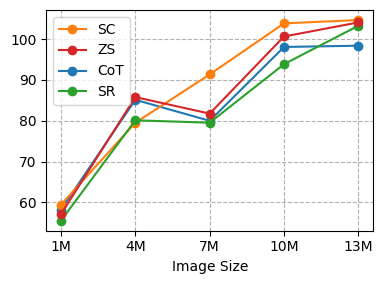

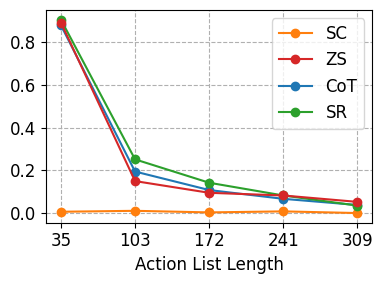

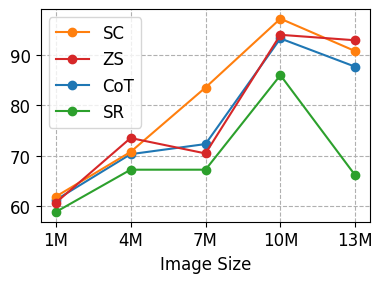

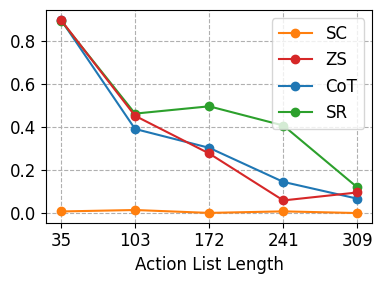

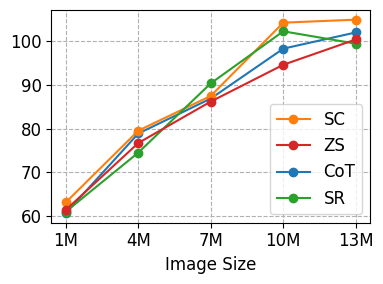

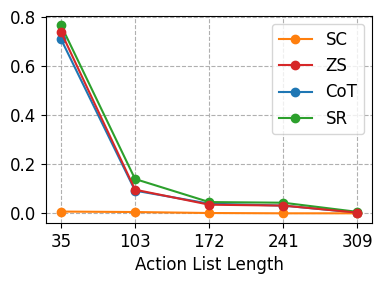

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("RQ3_complexity.csv")
data["method"] = data["method"].replace({"no": "SC", "direct": "ZS", "cot": "CoT", "self-refine": "SR"})
bin_num = 5

# Define 10 intervals for image_size and action_list_len
image_size_intervals = np.linspace(data['image_size'].min(), data['image_size'].max(), bin_num + 1)
action_list_len_intervals = np.linspace(data['action_list_len'].min(), data['action_list_len'].max(), bin_num + 1)

# Add interval columns for binning
data['image_size_interval'] = pd.cut(data['image_size'], bins=image_size_intervals, labels=range(1, bin_num + 1), include_lowest=True)
data['action_list_len_interval'] = pd.cut(data['action_list_len'], bins=action_list_len_intervals, labels=range(1, bin_num + 1), include_lowest=True)

# Group by model, method, and intervals for each figure type
image_size_grouped = data.groupby(['model', 'method', 'image_size_interval'], observed=True).mean(numeric_only=True).reset_index()
action_list_len_grouped = data.groupby(['model', 'method', 'action_list_len_interval'], observed=True).mean(numeric_only=True).reset_index()

# Unique models for plotting
models = data['model'].unique()
model_names = {'gemini': 'Gemini-Pro-1.5', 'gpt4o': 'GPT-4o', 'claude': 'Claude-3.5'}

# Plotting for each model
# Adding reordering of legends for the specified order ['NA', 'ZS', 'CoT', 'SR']

# Define the desired order for the legends
legend_order = ['SC', 'ZS', 'CoT', 'SR']

for model in models:
    # Subset for the current model
    image_size_subset = image_size_grouped[image_size_grouped['model'] == model]
    action_list_len_subset = action_list_len_grouped[action_list_len_grouped['model'] == model]

    # Plot MAE vs image size
    plt.figure(figsize=(4, 3))
    handles = []
    labels = []
    for method in image_size_subset['method'].unique():
        method_data = image_size_subset[image_size_subset['method'] == method]
        line, = plt.plot(method_data['image_size_interval'], method_data['MAE'], marker='o', label=method)
        handles.append(line)
        labels.append(method)
    # Reorder the legend based on the specified order
    ordered_handles = [handles[labels.index(method)] for method in legend_order if method in labels]
    plt.legend(ordered_handles, legend_order)
    plt.xticks(range(1, bin_num+1), [f'{int((image_size_intervals[i] + image_size_intervals[i+1]) / 2000000)}M' for i in range(bin_num)])
    plt.grid(True, linestyle='--')
    plt.xlabel('Image Size')
    # set larger font size for entire plot
    plt.rc('font', size=12)
    # plt.ylabel(r'MAE ($\downarrow$)')
    plt.tight_layout()
    plt.savefig(f'./figs/{model}_MAE.pdf')

    # Plot Match Ratio vs Action List Length
    plt.figure(figsize=(4, 3))
    handles = []
    labels = []
    for method in action_list_len_subset['method'].unique():
        method_data = action_list_len_subset[action_list_len_subset['method'] == method]
        line, = plt.plot(method_data['action_list_len_interval'], method_data['match_ratio'], marker='o', label=method)
        handles.append(line)
        labels.append(method)
    # Reorder the legend based on the specified order
    ordered_handles = [handles[labels.index(method)] for method in legend_order if method in labels]
    plt.legend(ordered_handles, legend_order)
    plt.xticks(range(1, bin_num+1), [f'{int((action_list_len_intervals[i] + action_list_len_intervals[i+1]) / 2)}' for i in range(bin_num)])
    plt.xlabel('Action List Length')
    # plt.ylabel(r'Act. Exist. Ratio ($\uparrow$)')
    plt.grid(True, linestyle='--')
    plt.rc('font', size=12)
    plt.tight_layout()
    plt.savefig(f'./figs/{model}_match_ratio.pdf')
